# Notebook 04 — Logistic Regression Baseline + Evaluation

## 04.0 Recreate Preprocessing Pipeline

In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

DATA_PATH = r"C:\Users\farbo\OneDrive\Desktop\churn-analysis\data\telco_churn_clean.csv"
df = pd.read_csv(DATA_PATH)

TARGET_COL = "churn"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]


for col in ["customerid", "customer_id", "id"]:
    if col in X.columns:
        X = X.drop(columns=[col])


numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)



## 04.1 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold, cross_val_score


## 04.2 Rebuild full pipeline (Preprocessing + Model)

In [5]:
# Default Logistic Regression
logreg_default = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

# Balanced Logistic Regression
logreg_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])


## 04.3 Train both models

In [6]:
logreg_default.fit(X_train, y_train)
logreg_balanced.fit(X_train, y_train)


d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'partner',
                                                   'dependents', 'phoneservice',
                                                   'multiplelines',
                                                   'internetservice',
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'deviceprotection',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## 04.4 Evaluate on Test Set

In [7]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= threshold).astype(int)

    roc_auc = roc_auc_score(y_test, probs)
    pr_auc = average_precision_score(y_test, probs)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}")
    print(f"F1-score (threshold={threshold}): {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    return probs


In [8]:
print("=== Logistic Regression (Default) ===")
probs_default = evaluate_model(logreg_default, X_test, y_test)


=== Logistic Regression (Default) ===
ROC-AUC: 0.8420
PR-AUC:  0.6336
F1-score (threshold=0.5): 0.6040

Confusion Matrix:
[[926 109]
 [165 209]]


In [9]:
print("=== Logistic Regression (Balanced) ===")
probs_balanced = evaluate_model(logreg_balanced, X_test, y_test)


=== Logistic Regression (Balanced) ===
ROC-AUC: 0.8417
PR-AUC:  0.6328
F1-score (threshold=0.5): 0.6136

Confusion Matrix:
[[747 288]
 [ 81 293]]


## 04.5 ROC Curve Plot

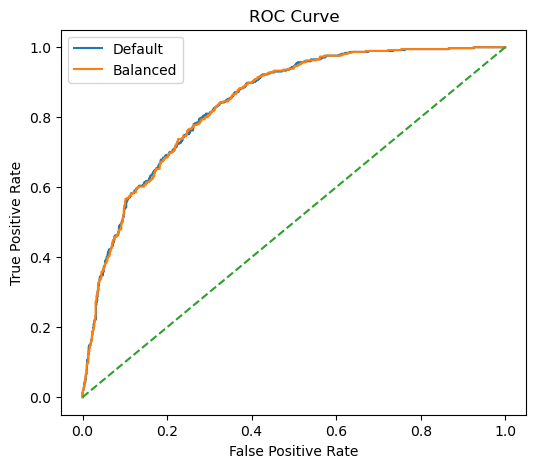

In [10]:
fpr_d, tpr_d, _ = roc_curve(y_test, probs_default)
fpr_b, tpr_b, _ = roc_curve(y_test, probs_balanced)

plt.figure(figsize=(6,5))
plt.plot(fpr_d, tpr_d, label="Default")
plt.plot(fpr_b, tpr_b, label="Balanced")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## 04.6 Precision-Recall Curve

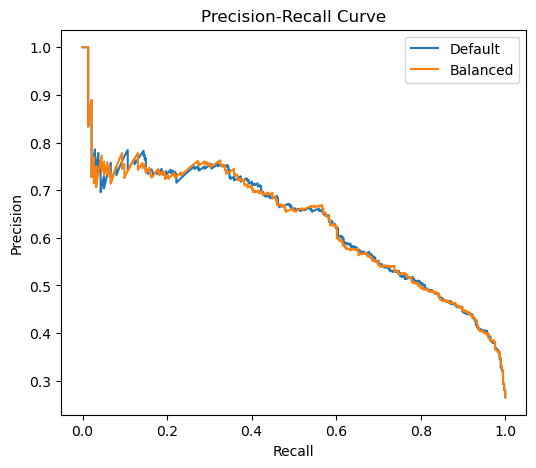

In [11]:
prec_d, rec_d, _ = precision_recall_curve(y_test, probs_default)
prec_b, rec_b, _ = precision_recall_curve(y_test, probs_balanced)

plt.figure(figsize=(6,5))
plt.plot(rec_d, prec_d, label="Default")
plt.plot(rec_b, prec_b, label="Balanced")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


## 04.7 Stratified K-Fold Cross-Validation

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    logreg_balanced,
    X_train,
    y_train,
    cv=skf,
    scoring="roc_auc"
)

print("Cross-Validated ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())
print("Std ROC-AUC:", cv_scores.std())


d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `spa

Cross-Validated ROC-AUC Scores: [0.84713942 0.82544472 0.84153297 0.86269247 0.85303288]
Mean ROC-AUC: 0.8459684914545447
Std ROC-AUC: 0.012424711054978532


d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 04.8 Threshold Discussion (Business Perspective)

In [13]:
print("=== Balanced Model (Threshold = 0.3) ===")
evaluate_model(logreg_balanced, X_test, y_test, threshold=0.3)


=== Balanced Model (Threshold = 0.3) ===
ROC-AUC: 0.8417
PR-AUC:  0.6328
F1-score (threshold=0.3): 0.5871

Confusion Matrix:
[[574 461]
 [ 27 347]]


array([0.1177368 , 0.8519486 , 0.14600094, ..., 0.336413  , 0.01322336,
       0.01777641])

## Business Interpretation

### Logistic Regression Findings

- Balanced model improved recall compared to default.
- ROC-AUC indicates strong discriminative ability.
- Lowering decision threshold increases churn detection at the expense of false positives.
- For retention campaigns, higher recall may be preferable to avoid missing at-risk customers.
